In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/sebastian/masters/') # add my repo to python path
import os
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import modules
import matplotlib.pyplot as plt
import re
import Bio
from Bio.Align import substitution_matrices

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, BatchSampler
from sklearn.metrics import *
from torch import nn, optim
from pathlib import Path

from modules.dataset_utils import *
from modules.dataset import *
from modules.utils import *
from modules.models import *
from modules.lstm_utils import *

from scipy.stats import ttest_ind, describe, ttest_rel

from Bio.PDB.PDBExceptions import PDBConstructionWarning

import warnings
warnings.simplefilter('ignore', PDBConstructionWarning)


np.random.seed(0)
torch.manual_seed(0)

In [2]:
root = Path("/home/sebastian/masters/data/")
data_root = root / "neat_data"
metadata_path = data_root / "metadata.csv"
processed_dir = data_root / "processed"
state_file = root / "state_files" / "e53-s1952148-d93703104.state"
out_dir = root / "results_2"

model_dir = data_root / "raw" / "tcrpmhc"

paths = list(model_dir.glob("*"))
join_key = [int(x.name.split("_")[0]) for x in paths]
path_df = pd.DataFrame({'#ID': join_key, 'path': paths})

metadata = pd.read_csv(metadata_path)
metadata = metadata.join(path_df.set_index("#ID"), on="#ID", how="inner")  # filter to non-missing data
metadata = metadata.reset_index(drop=True)
unique_peptides = metadata["peptide"].unique()

In [3]:
metadata

,#ID,CDR3a,CDR3b,peptide,partition,binder,v_gene_alpha,j_gene_alpha,v_gene_beta,j_gene_beta,origin,v_alpha_vdjdb_name,j_alpha_vdjdb_name,v_beta_vdjdb_name,j_beta_vdjdb_name,path
0,1,AVSQSNTGKLI,ASSQLMENTEAF,NLVPMVATV,1,0,TRAV12-2,TRAJ37,TRBV4-1,TRBJ1-1,tenX,TRAV12-2*01,TRAJ37*01,TRBV4-1*01,TRBJ1-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...
1,2,AASEVCADYKLS,ASSYSLLRAAPNTEAF,NLVPMVATV,1,0,TRAV29DV5,TRAJ20,TRBV6-3,TRBJ1-1,tenX,TRAV29/DV5*01,TRAJ20*01,TRBV6-3*01,TRBJ1-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...
2,3,AGRLGAQKLV,ASSQGGRRNQPQH,NLVPMVATV,1,0,TRAV25,TRAJ54,TRBV4-2,TRBJ1-5,tenX,TRAV25*01,TRAJ54*01,TRBV4-2*01,TRBJ1-5*01,/home/sebastian/masters/data/neat_data/raw/tcr...
3,4,AVEPLYGNKLV,ASSSREAEAF,NLVPMVATV,1,0,TRAV22,TRAJ47,TRBV7-9,TRBJ1-1,tenX,TRAV22*01,TRAJ47*01,TRBV7-9*01,TRBJ1-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...
4,5,ASGTYKYI,ASSQRAGRVDTQY,NLVPMVATV,1,0,TRAV19,TRAJ40,TRBV27,TRBJ2-3,tenX,TRAV19*01,TRAJ40*01,TRBV27*01,TRBJ2-3*01,/home/sebastian/masters/data/neat_data/raw/tcr...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10326,12961,AVNSYYNQGGKLI,SVLQGSPYEQY,GILGFVFTL,1,1,TRAV12-2*01,TRAJ23*01,TRBV29-1*01,TRBJ2-7*01,positive,TRAV12-2*01,TRAJ23*01,TRBV29-1*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...
10327,12962,AGNYGGSQGNLI,ASSIYSVNEQF,GILGFVFTL,1,1,TRAV35*01,TRAJ42*01,TRBV19*01,TRBJ2-1*01,positive,TRAV35*01,TRAJ42*01,TRBV19*01,TRBJ2-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...
10328,12966,AVGGSQGNLI,ASSVRSSYEQY,GILGFVFTL,1,1,TRAV8-6*02,TRAJ42*01,TRBV19*01,TRBJ2-7*01,positive,TRAV8-6*01,TRAJ42*01,TRBV19*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...
10329,12968,AENGGGGADGLT,ASSIRSSYEQY,GILGFVFTL,1,1,TRAV13-2*01,TRAJ45*01,TRBV19*01,TRBJ2-7*01,positive,TRAV13-2*01,TRAJ45*01,TRBV19*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...


TRAV27*01
TRAJ42*01
TRBV19*01
TRBJ2-7


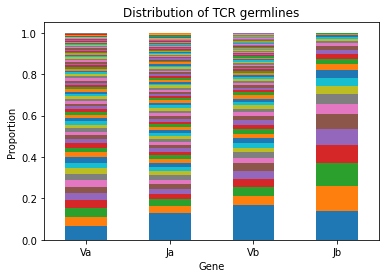

In [149]:
counts = list()
for i, gene in enumerate(["v_gene_alpha", "j_gene_alpha", "v_gene_beta", "j_gene_beta"]):
    new_df = pd.DataFrame()
    names = list(metadata[gene].value_counts().index)
    vals = list(metadata[gene].value_counts())
    vals = [x/sum(vals) for x in vals]
    counts.append(vals)
    print(names[0])

new_counts = list()
max_len = max([len(x) for x in counts])
for gene, vals in zip(["Va", "Ja", "Vb", "Jb"], counts):
    diff = max_len - len(vals)
    vals = [gene] + vals + (diff * [0])
    new_counts.append(vals)
    
new_df = pd.DataFrame(columns=["name"] + [x for x in range(max_len)], data=new_counts)
#new_df = pd.DataFrame({k: v for k, v in zip(["name"] + names, [gene] + vals)}, index=[i])
#master_df = pd.merge_ordered(master_df, new_df)
new_df.plot(
    x = "name", 
    ylabel = "Proportion",
    xlabel = "Gene",
    kind = 'bar', 
    stacked = True, 
    title = 'Distribution of TCR germlines', 
    legend=False,
    rot=0)
plt.savefig("overall_germlines.png", dpi=300)

TRAV27*01
TRAJ42*01
TRBV19*01
TRBJ2-7*01


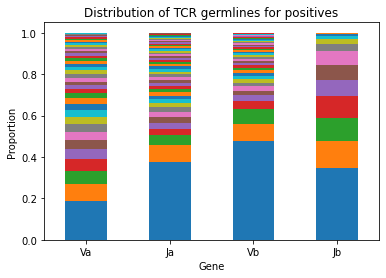

In [148]:
counts = list()
for i, gene in enumerate(["v_gene_alpha", "j_gene_alpha", "v_gene_beta", "j_gene_beta"]):
    names = list(metadata[metadata["origin"] == "positive"][gene].value_counts().index)
    vals = list(metadata[metadata["origin"] == "positive"][gene].value_counts())
    vals = [x/sum(vals) for x in vals]
    counts.append(vals)
    print(names[0])

new_counts = list()
max_len = max([len(x) for x in counts])
for gene, vals in zip(["Va", "Ja", "Vb", "Jb"], counts):
    diff = max_len - len(vals)
    vals = [gene] + vals + (diff * [0])
    new_counts.append(vals)
    
new_df = pd.DataFrame(columns=["name"] + [x for x in range(max_len)], data=new_counts)
#new_df = pd.DataFrame({k: v for k, v in zip(["name"] + names, [gene] + vals)}, index=[i])
#master_df = pd.merge_ordered(master_df, new_df)
new_df.plot(
    x = "name",
    ylabel = "Proportion",
    xlabel = "Gene",
    kind = 'bar', 
    stacked = True, 
    title = 'Distribution of TCR germlines for positives', 
    legend=False,
    rot=0)
plt.savefig("positives_germlines.png", dpi=300)

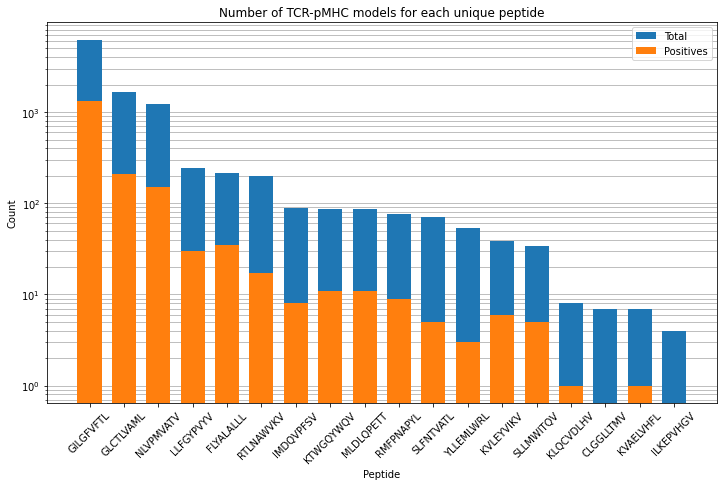

In [7]:
# quick viz
count_dict = dict()
for pep in unique_peptides:
    total = len(metadata[metadata["peptide"] == pep])
    pos = len(metadata[(metadata["peptide"] == pep) & (metadata["binder"] == 1)])
    count_dict[pep] = [total, pos]
    
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)

peptides = np.array(list(count_dict.keys()))
counts = np.array([count_dict[pep][0] for pep in peptides])
positive_counts = np.array([count_dict[pep][1] for pep in peptides])
sorted_idx = counts.argsort()[::-1]
sorted_counts = counts[sorted_idx]
sorted_peptides = peptides[sorted_idx]
sorted_positives = positive_counts[sorted_idx]

#negatives = [x[0] - x[1] for x in count_dict.values()]
#positives = [x[1] for x in count_dict.values()]

width = 0.7
idx = np.arange(len(unique_peptides))

ax.bar(idx, sorted_counts, width, zorder=3)
ax.bar(idx, sorted_positives, width, zorder=3)
ax.set_yscale('log')
ax.set_xticks(idx)
ax.set_xticklabels(sorted_peptides, rotation=45)

ax.grid(zorder=0, which='both', axis='y')

plt.legend(["Total", "Positives"])
plt.xlabel("Peptide")
plt.ylabel("Count")
plt.title("Number of TCR-pMHC models for each unique peptide")
plt.savefig("peptide_count.png", dpi=300)
plt.show()



In [16]:
data_rows = list()
origin = list()

aligner = Bio.Align.PairwiseAligner(mode="global")
aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")

for pred_idx, tcrpmhc_path in zip(metadata.index, metadata["path"]):
    model_idx = Path(tcrpmhc_path).name.split("_")[0]
    tcr_path = root / "210916_TCRpMHCmodels" / "models" / f"{model_idx}_model" / "model_TCR.pdb"
    
    if tcr_path.is_file():
        data_dict = dict()
        with open(tcr_path, "r") as pdb_parse:
            for line in pdb_parse:
                template_match = re.search(r"LOOP\s+([AB]\d)\s+TEMPLATE\s+SEQUENCE:\s+(\w+)", line)
                if template_match:
                    template_loop = template_match.group(1)
                    template_seq = template_match.group(2)
                    data_dict[f"{template_loop}_template"] = template_seq

                input_match = re.search(r"LOOP\s+([AB]\d)\s+INPUT\s+SEQUENCE:\s+(\w+)", line)
                if input_match:
                    input_loop = input_match.group(1)
                    input_seq = input_match.group(2)
                    data_dict[f"{input_loop}_input"] = input_seq

        data_row = list()
        for cdr in ["A1", "A2", "A3", "B1", "B2", "B3"]:
            template_seq = data_dict[f"{cdr}_template"]
            input_seq = data_dict[f"{cdr}_input"]
            alignment = aligner.align(template_seq, input_seq)
            #data_row.append(alignment.score/list(alignment)[0].shape[1])
            data_row.append(alignment.score/max([len(template_seq), len(input_seq)]))

        super_imposer = Bio.PDB.Superimposer()

        parser = Bio.PDB.PDBParser()
        tcr_structure = parser.get_structure("tcr", tcr_path)[0]

        parser = Bio.PDB.PDBParser()
        tcrpmhc_structure = parser.get_structure("tcrpmhc", tcrpmhc_path)[0]

        tcr_atoms = list()
        tcrpmhc_atoms = list()
        for chain_id in ["A", "B"]:
            for res_tcr, res_tcrpmhc in zip(tcr_structure[chain_id], tcrpmhc_structure[chain_id]):
                for bb_atom in ["CA", "C", "N", "O"]:
                    if bb_atom in res_tcr and bb_atom in res_tcrpmhc:
                        tcr_atoms.append(res_tcr[bb_atom])
                        tcrpmhc_atoms.append(res_tcrpmhc[bb_atom])

        super_imposer.set_atoms(tcr_atoms, tcrpmhc_atoms)
        super_imposer.apply(tcrpmhc_structure.get_atoms())

        data_row.append(super_imposer.rms)
        origin = list(metadata[metadata["#ID"] == int(model_idx)]["origin"])[0]
        data_rows.append(
            [pred_idx, model_idx, origin] + data_row
        )
        
        
        if int(model_idx) in [1, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]:
            print(model_idx)

data_df = pd.DataFrame(
    data_rows,
    columns=[
    "pred_idx",
    "model",
    "origin",
    "cdr1a_score", 
    "cdr2a_score", 
    "cdr3a_score", 
    "cdr1b_score", 
    "cdr2b_score", 
    "cdr3b_score", 
    "tcr_rmsd"
])

In [21]:
data_df

,pred_idx,model,origin,cdr1a_score,cdr2a_score,cdr3a_score,cdr1b_score,cdr2b_score,cdr3b_score,tcr_rmsd
0,0,1,tenX,5.222222,5.500000,2.500000,5.666667,4.944444,2.833333,1.017320
1,1,2,tenX,5.777778,4.571429,2.769231,5.666667,5.444444,2.125000,0.904631
2,2,3,tenX,2.125000,2.500000,3.636364,4.777778,3.444444,3.000000,0.941877
3,3,4,tenX,5.000000,5.200000,2.833333,5.444444,4.947368,3.000000,1.211492
4,4,5,tenX,5.600000,5.375000,2.666667,5.666667,5.388889,3.461538,0.947736
...,...,...,...,...,...,...,...,...,...,...
10326,10326,12961,positive,5.222222,5.500000,2.642857,1.888889,3.650000,3.545455,1.553807
10327,10327,12962,positive,5.500000,5.000000,3.615385,5.444444,5.222222,3.272727,1.577388
10328,10328,12966,positive,3.777778,3.000000,4.636364,5.444444,5.222222,4.454545,1.422134
10329,10329,12968,positive,4.222222,3.142857,3.000000,5.444444,5.222222,4.454545,1.392869


In [20]:
#data_df.to_csv(data_root / "model_quality_proxies.csv")
data_df.from_csv(data_root / "model_quality_proxies.csv")

/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Crea

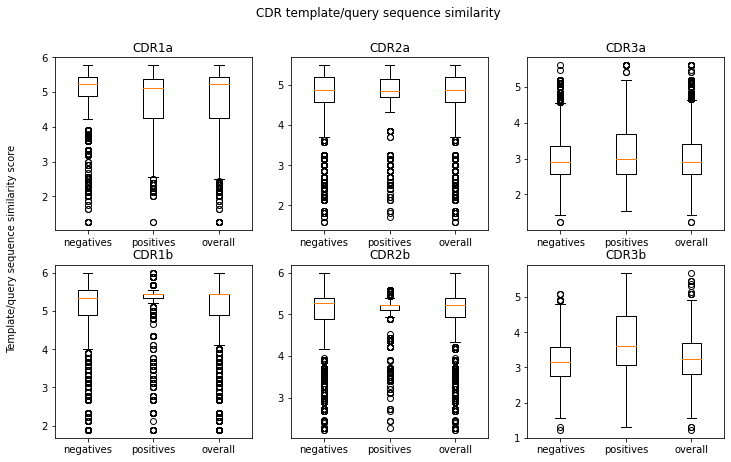

In [77]:
fig, axs = plt.subplots(2, 3, figsize=(12,7))
labels = ["negatives", "positives", "overall"]

# basic plot
axs[0, 0].boxplot([
    data_df[data_df["origin"] == "tenX"]["cdr1a_score"],
    data_df[data_df["origin"] == "swapped"]["cdr1a_score"],
    data_df[(data_df["origin"] == "positive") | (data_df["origin"] == "tenX")]["cdr1a_score"]
],
    labels=labels)
axs[0, 0].set_title('CDR1a')

# notched plot
axs[0, 1].boxplot([
    data_df[data_df["origin"] == "tenX"]["cdr2a_score"],
    data_df[data_df["origin"] == "swapped"]["cdr2a_score"],
    data_df[(data_df["origin"] == "positive") | (data_df["origin"] == "tenX")]["cdr2a_score"]],
    labels=labels)
axs[0, 1].set_title('CDR2a')

# change outlier point symbols
axs[0, 2].boxplot([
    data_df[data_df["origin"] == "tenX"]["cdr3a_score"],
    data_df[data_df["origin"] == "swapped"]["cdr3a_score"],
    data_df[(data_df["origin"] == "positive") | (data_df["origin"] == "tenX")]["cdr3a_score"]],
    labels=labels)
axs[0, 2].set_title('CDR3a')

# don't show outlier points
axs[1, 0].boxplot([
    data_df[data_df["origin"] == "tenX"]["cdr1b_score"],
    data_df[data_df["origin"] == "swapped"]["cdr1b_score"],
    data_df[(data_df["origin"] == "positive") | (data_df["origin"] == "tenX")]["cdr1b_score"]],
    labels=labels)
axs[1, 0].set_title('CDR1b')

# horizontal boxes
axs[1, 1].boxplot([
    data_df[data_df["origin"] == "tenX"]["cdr2b_score"],
    data_df[data_df["origin"] == "swapped"]["cdr2b_score"],
    data_df[(data_df["origin"] == "positive") | (data_df["origin"] == "tenX")]["cdr2b_score"]],
    labels=labels)
axs[1, 1].set_title('CDR2b')

# horizontal boxes
axs[1, 2].boxplot([
    data_df[data_df["origin"] == "tenX"]["cdr3b_score"],
    data_df[data_df["origin"] == "swapped"]["cdr3b_score"],
    data_df[(data_df["origin"] == "positive") | (data_df["origin"] == "tenX")]["cdr3b_score"]],
    labels=labels)
axs[1, 2].set_title('CDR3b')

fig.suptitle("CDR template/query sequence similarity")
fig.text(0.07, 0.5, 'Template/query sequence similarity score', va='center', rotation='vertical')
fig.savefig("cdr_seq_id.png", dpi=300)
#fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
#                    hspace=0.4, wspace=0.3)

/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


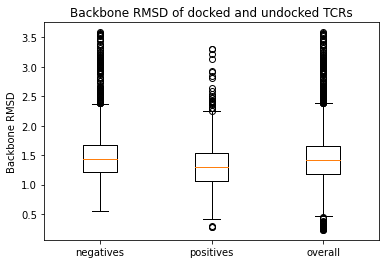

In [78]:
# alignment failed for a couple structures and they are excluded (rmsd > 6)
plt.boxplot([
    data_df[(data_df["origin"] == "tenX") & (data_df["tcr_rmsd"] < 6)]["tcr_rmsd"],
    data_df[(data_df["origin"] == "swapped") & (data_df["tcr_rmsd"] < 6)]["tcr_rmsd"],
    data_df[(((data_df["origin"] == "positive") | (data_df["origin"] == "tenX")) &  (data_df["tcr_rmsd"] < 6))]["tcr_rmsd"]],
labels=labels)
plt.ylabel("Backbone RMSD")
plt.title("Backbone RMSD of docked and undocked TCRs")
plt.savefig("tcr_rmsd_id.png", dpi=300)


In [68]:
data_df[data_df["tcr_rmsd"] > 10]

,pred_idx,model,origin,cdr1a_score,cdr2a_score,cdr3a_score,cdr1b_score,cdr2b_score,cdr3b_score,tcr_rmsd
96,96,115,tenX,2.125,2.5,3.090909,5.111111,5.333333,2.928571,11.721290
136,136,167,tenX,2.125,2.5,3.583333,4.777778,4.421053,3.800000,11.946066
397,397,506,tenX,2.125,2.5,3.357143,5.666667,5.388889,3.153846,12.023305
423,423,541,tenX,2.125,2.5,3.000000,5.222222,5.315789,2.571429,11.917802
572,572,709,tenX,2.125,2.5,2.400000,3.666667,4.388889,3.400000,11.726082
...,...,...,...,...,...,...,...,...,...,...
10200,10200,12812,positive,2.125,2.5,3.400000,5.444444,5.222222,4.454545,11.865723
10228,10228,12846,positive,2.125,2.5,3.692308,5.444444,5.222222,4.000000,11.994153
10245,10245,12868,positive,2.125,2.5,3.000000,5.444444,5.222222,2.454545,11.988196
10266,10266,12890,positive,2.125,2.5,3.846154,5.444444,5.222222,2.363636,12.011706
